### Import Required Libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import gaussian_kde,ecdf
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline,LinearNDInterpolator
from scipy.optimize import fsolve
import time
import pandas as pd
import os
from sklearn.linear_model import LinearRegression

### Viscous_parameters_solver Function

In [2]:
def viscous_parameters_solver(t, theta,mobject):
    l = 0.6505
    r = 0.36115625
    g = 9.7949
    mnet = 2.974+mobject #FIRST NUMBER IS DISK AND SENSOR, NOT INCLUDING TRANSMITTER
    noise_param = 0.04

     # Trim NaN values from t and theta
    validIndicies = ~np.isnan(theta)
    t = t[validIndicies]
    theta = theta[validIndicies]
    
    # Filter the data
    b, a = butter(4, 0.05, 'low')
    filtered_theta = filtfilt(b, a, theta)
    peak_filtering_param = 3 #remember to adjust as to remove outliers associated with signal noise

    

    # Use find_peaks with adjusted parameters to identify peaks
    peaks, _ = find_peaks(filtered_theta, prominence=np.deg2rad(noise_param*peak_filtering_param))  # adjust prominence if needed

    # Check if peaks are found
    if len(peaks) == 0:
        print("No peaks were found.")
        return [0, 0, 0, 0]

    # Calculate the periods between peaks
    periods = np.diff(t[peaks])
    # plt.figure()
    # plt.plot(t,theta,'kx',ms=1)
    # plt.plot(t,filtered_theta,'r-')
    # plt.xlim((0,15))
    # plt.show()
    # plt.figure()
    # plt.plot(periods)
    # plt.show()
    # Calculate median filtered period
    T_d = np.median(periods)
    # print(f"T_d = {T_d}", end='\n')
    omega_d = (2 * np.pi) / T_d
    # print(f"Calculated wd = {omega_d}", end='\n')

    # Calculate the damping ratio
    amplitude_ratios = filtered_theta[peaks][1:] / filtered_theta[peaks][:-1]
    damping_ratios = -1*np.log(amplitude_ratios)
    # print(f"Calculated dr = {np.median(damping_ratios)}",end='\n')
    zeta = np.median(damping_ratios) / ( np.sqrt( (4 * np.pi ** 2) + (np.median(damping_ratios) ** 2) ) )
    # print(f"Calculated zeta = {zeta}",end='\n')

    # Calculate natural frequency and inertia
    omega_n = omega_d / np.sqrt(1 - zeta ** 2)
    Inet_pure = (mnet * g * r ** 2) / (l * omega_n ** 2)
    c_pure = zeta * 2 * np.sqrt(Inet_pure * ((mnet * g * r ** 2) / l))

    return [Inet_pure, (mnet * g * r ** 2) / l, c_pure, 0]


#### Calculating Disk Inertia, Known Inertia Values

In [3]:
# # Importing Disk Data
folder_path = '/home/coder/workspace/Finnamore/I_2C'
disk_path = '/home/coder/workspace/Finnamore/I_D'
numTests = 45
df_disk_data = {}
disk_inertia_data = np.zeros(numTests)
disk_period_data = np.zeros(numTests)

# Importing and Calculating Disk Inertial Data
for i in range(numTests):
    # File Path Creation
    file_name = 'I_D_{:02}.csv'.format(i)
    file_path = os.path.join(disk_path,file_name)

    #Reading in Data
    df = pd.read_csv(file_path,usecols=[0,1])
    df_disk_data[i] = df.values

    #Converting from Miliseconds to Seconds
    df_disk_data[i][:,0] = np.divide(df_disk_data[i][:,0],1000)

    #Solving for Disk Inertia
    disk_inertia_data[i] = viscous_parameters_solver(df_disk_data[i][:,0],df_disk_data[i][:,1],0)[0]

#Setting up Dicitonary of Known Inertial Values
disk_inertia = np.median(disk_inertia_data)
disk_period = np.median(disk_period_data)
I_names = ['11','10','09','08','7','6','5','4']
# disk_inertia = 0.2035
m_single_weight = .4465
I_single_cylinder = 0.5*m_single_weight*(0.0254**2)
# Calculating and Storing Known Inertial Values

actual_inertias = {}
for name in I_names:
    actual_inertias[name] = np.ones(numTests)*2*(I_single_cylinder+(m_single_weight*((0.0254*(int(name)+1))**2)))

### Import Data


In [4]:

raw_data = {}
inertia_data = {}
period_data = {}
# Define the pattern or names of your CSV files
for name in I_names:
    raw_data[name] = {}
    inertia_data[name] = np.zeros(numTests)
    period_data[name] = np.zeros(numTests)
    for i in range(numTests):
        file_name = ('I_2C_{}'.format(name))+'_{:02}.csv'.format(i)
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path, usecols=[0, 1])
        raw_data[name][i] = df.values
        raw_data[name][i][:,0] = np.divide(raw_data[name][i][:,0],1000)
        inertia_data[name][i] = viscous_parameters_solver(raw_data[name][i][:,0],raw_data[name][i][:,1],2*m_single_weight)[0] - disk_inertia


### Plot/Print Results

Text(0.5, 1.0, 'True Inertia Value vs Precision')

<Figure size 640x480 with 0 Axes>

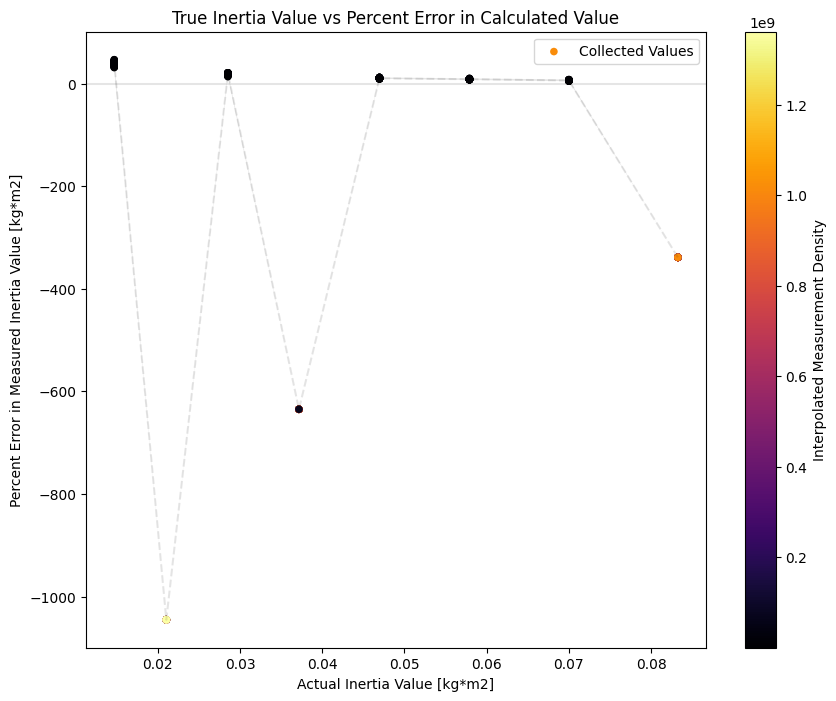

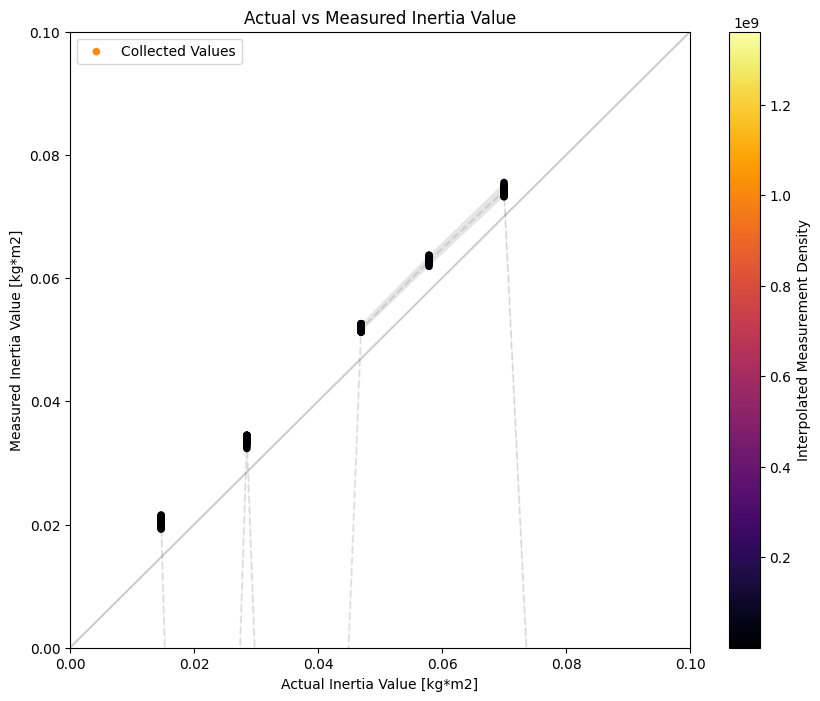

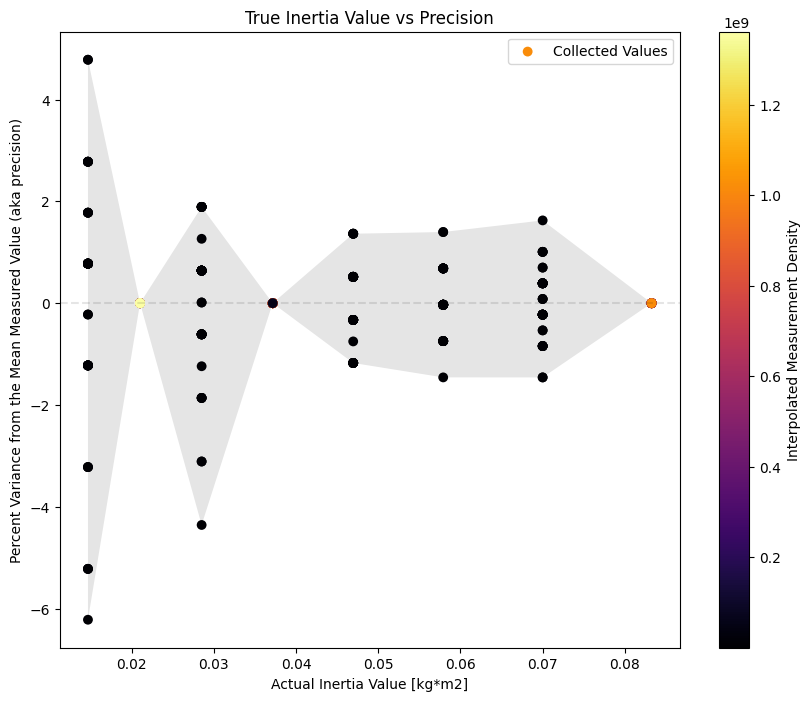

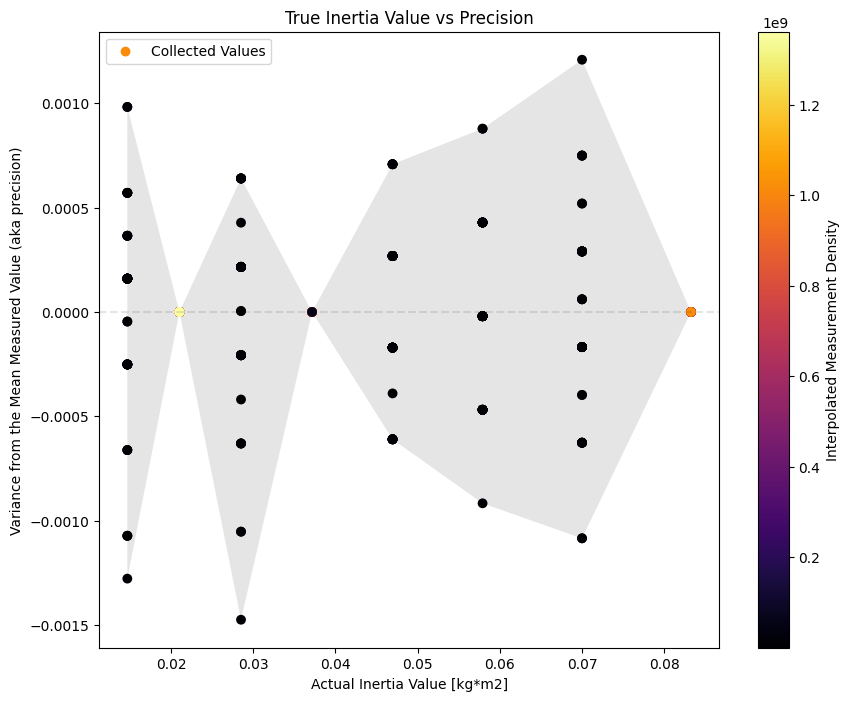

In [5]:
actualInertias = np.array([])
measuredInertias = np.array([])
kde_results = np.array([])
varianceFromMean = np.array([])
errorFromMean = np.array([])  
xvals = np.array([])
minError = np.array([])
medError = np.array([])
maxError = np.array([])
percentError = np.array([])
minVariance = np.array([])
maxVariance = np.array([])
minErrorMean = np.array([])
maxErrorMean = np.array([])
maxes = np.array([])
mins = np.array([])
meds = np.array([])
# inertia_data['1'][numTests-1] = np.mean(inertia_data['1'][0:numTests-2])
for name in I_names:
    actualInertias = np.concatenate((actualInertias,actual_inertias[name]))
    measuredInertias = np.concatenate((measuredInertias,inertia_data[name]))

# #This part because I have mental illness

# x = measuredInertias.reshape((-1,1))
# y = actualInertias
# model = LinearRegression().fit(x, y)
# a = model.coef_
# b = model.intercept_
# print("Model Coefficient: {}".format(a))
# print('Model Intercept: {}'.format(b))
# print('Model r**2: {}'.format(model.score(x,y)))
# measuredInertias = measuredInertias*a + b

for name in I_names:
    # inertia_data[name] = inertia_data[name]*a + b
    error = ((inertia_data[name]-actual_inertias[name][0])/(actual_inertias[name][0]))*100
    errorMean = (inertia_data[name]-np.mean(inertia_data[name]))
    variance = ((inertia_data[name]-np.mean(inertia_data[name]))/(np.mean(inertia_data[name])))*100
    varianceFromMean = np.concatenate((varianceFromMean,variance))
    errorFromMean = np.concatenate((errorFromMean,errorMean))
    percentError = np.concatenate((percentError,error))
    kde = gaussian_kde(inertia_data[name])
    kde_results = np.concatenate((kde_results,kde(inertia_data[name])))
    xvals = np.append(xvals,actual_inertias[name][0])
    minError = np.append(minError,np.min(error))
    maxError = np.append(maxError,np.max(error))
    medError = np.append(medError,np.median(error))
    minErrorMean = np.append(minErrorMean,np.min(errorMean))
    maxErrorMean = np.append(maxErrorMean,np.max(errorMean))
    minVariance = np.append(minVariance,np.min(variance))
    maxVariance = np.append(maxVariance,np.max(variance))
    maxes = np.append(maxes,np.max(inertia_data[name]))
    mins = np.append(mins,np.min(inertia_data[name]))
    meds = np.append(meds,np.median(inertia_data[name]))


    
#  Plotting Percent Error
plt.set_cmap('inferno')
fig,ax = plt.subplots(figsize=(10,8))
ax.set_facecolor('white')
plt.plot(xvals,medError,c='k',linestyle='--',alpha=0.1)
plt.axhline(y=0,linestyle='-',c='k',alpha=0.1)
plt.fill_between(xvals,minError,maxError,color='k',alpha=0.1,edgecolors='none')
scatter = ax.scatter(actualInertias,percentError,c=kde_results,marker='o',edgecolors='none',s=30,label='Collected Values')
fig.colorbar(scatter, ax=ax, label='Interpolated Measurement Density')
plt.legend()
plt.xlabel('Actual Inertia Value [kg*m2]')
plt.ylabel('Percent Error in Measured Inertia Value [kg*m2]')
plt.title('True Inertia Value vs Percent Error in Calculated Value')

# Plotting Actual Values
plt.set_cmap('inferno')
fig,ax = plt.subplots(figsize=(10,8))
ax.set_facecolor('white')
plt.plot(xvals,meds,c='k',linestyle='--',alpha=0.1)
plt.plot(np.linspace(0,0.1,1000),np.linspace(0,0.1,1000),c='k',linestyle='-',alpha=0.2)
plt.fill_between(xvals,mins,maxes,color='k',alpha=0.1,edgecolors='none')
scatter = ax.scatter(actualInertias,measuredInertias,c=kde_results,marker='o',edgecolors='none',s=30,label='Collected Values')
fig.colorbar(scatter, ax=ax, label='Interpolated Measurement Density')
plt.legend()
plt.xlabel('Actual Inertia Value [kg*m2]')
plt.ylabel('Measured Inertia Value [kg*m2]')
plt.title('Actual vs Measured Inertia Value')
plt.xlim((0,0.1))
plt.ylim((0,0.1))

# Plotting Variance from Mean
plt.set_cmap('inferno')
fig,ax = plt.subplots(figsize=(10,8))
ax.set_facecolor('white')
plt.axhline(y=0,linestyle='--',c='k',alpha=0.1)
plt.fill_between(xvals,minVariance,maxVariance,color='k',alpha=0.1,edgecolors='none')
scatter = ax.scatter(actualInertias,varianceFromMean,c=kde_results,marker='o',edgecolors='none',s=50,label='Collected Values')
fig.colorbar(scatter, ax=ax, label='Interpolated Measurement Density')
plt.legend()
plt.xlabel('Actual Inertia Value [kg*m2]')
plt.ylabel('Percent Variance from the Mean Measured Value (aka precision)')
plt.title('True Inertia Value vs Precision')

# Plotting Variance from Mean
plt.set_cmap('inferno')
fig,ax = plt.subplots(figsize=(10,8))
ax.set_facecolor('white')
plt.axhline(y=0,linestyle='--',c='k',alpha=0.1)
plt.fill_between(xvals,minErrorMean,maxErrorMean,color='k',alpha=0.1,edgecolors='none')
scatter = ax.scatter(actualInertias,errorFromMean,c=kde_results,marker='o',edgecolors='none',s=50,label='Collected Values')
fig.colorbar(scatter, ax=ax, label='Interpolated Measurement Density')
plt.legend()
plt.xlabel('Actual Inertia Value [kg*m2]')
plt.ylabel('Variance from the Mean Measured Value (aka precision)')
plt.title('True Inertia Value vs Precision')